# Business problem we are trying to solve

# 0. Import the necessary libraries

In [27]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from pathlib import Path
from yellowbrick.model_selection import FeatureImportances
import shap
import joblib
%matplotlib inline

# 1. Get the data

## 1.1 Import csv file

In [4]:
train_original = pd.read_csv('datasets/train.csv')
test_original = pd.read_csv('datasets/test.csv')

## 1.2 Split the data into training and test sets

In [5]:
train_original.shape

(30000, 24)

In [6]:
test_original.shape

(20000, 23)

In [7]:
train_original.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')

In [8]:
test_original.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price'],
      dtype='object')

In [10]:
pd.set_option('display.max_columns', None)
train_original.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,241.08,N,N,3.0,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,495.81,N,Y,1.0,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,171.95,N,Y,1.0,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,298.54,N,Y,2.0,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,491.41,N,Y,NaN,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28


In [11]:
test_original.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price
0,C-26247,Tandra Olszewski,F,47,3472.69,Low,Commercial associate,Managers,Semi-Urban,137088.98,396.72,N,N,2.0,799.14,0,Unpossessed,843,3472.69,2,Urban,1,236644.5
1,C-35067,Jeannette Cha,F,57,1184.84,Low,Working,Sales staff,Rural,104771.59,463.76,Y,Y,2.0,833.31,0,Unpossessed,22,1184.84,1,Rural,1,142357.3
2,C-34590,Keva Godfrey,F,52,1266.27,Low,Working,NaN,Semi-Urban,176684.91,493.15,N,Y,3.0,627.44,0,Unpossessed,1,1266.27,1,Urban,1,300991.24
3,C-16668,Elva Sackett,M,65,1369.72,High,Pensioner,NaN,Rural,97009.18,446.15,N,Y,2.0,833.20,0,Inactive,730,1369.72,1,Semi-Urban,0,125612.1
4,C-12196,Sade Constable,F,60,1939.23,High,Pensioner,NaN,Urban,109980.00,370.10,N,N,NaN,NaN,0,NaN,356,1939.23,4,Semi-Urban,1,180908.0


Since the test dataset does not have the target variable (Loan Sanction Amount), we will split the train dataset into a new train and test dataset.

In [12]:
full_data = train_original

In [13]:
full_data.shape

(30000, 24)

In [17]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [19]:
loan_amt_train_original, loan_amt_test_original = data_split(full_data, 0.2)

In [20]:
loan_amt_train_copy, loan_amt_test_copy = loan_amt_train_original.copy(), loan_amt_test_original.copy()

In [22]:
loan_amt_train_copy.shape

(24000, 24)

In [23]:
loan_amt_test_copy.shape

(6000, 24)

# 2. Explore the data

## 2.1 Quick glance at the data

In [40]:
loan_amt_train_copy.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-15808,Minerva Dundon,M,27,12398.65,Low,Working,Managers,Urban,294604.89,1255.89,Y,N,2.0,NaN,0,Active,540,12398.65,4,Semi-Urban,1,526542.91,235683.91
1,C-29367,Darius Granado,M,36,NaN,Low,Working,NaN,Semi-Urban,132263.08,500.43,N,N,1.0,646.05,1,NaN,320,NaN,3,Urban,1,250293.24,0.00
2,C-20386,Verlene Hagar,M,52,NaN,Low,Commercial associate,Sales staff,Semi-Urban,112307.54,539.09,N,Y,1.0,706.42,0,Active,6,NaN,2,Rural,1,157866.23,72999.90
3,C-14237,Yang Leitner,F,18,NaN,Low,Working,Laborers,Rural,24268.35,168.21,N,N,2.0,640.23,0,Unpossessed,869,NaN,2,Urban,1,30470.51,0.00
4,C-14759,Ilda Jeffords,F,18,2203.52,Low,Working,Laborers,Semi-Urban,76342.04,681.95,N,Y,2.0,835.55,0,Inactive,21,2203.52,3,Urban,1,142224.12,57256.53


In [41]:
loan_amt_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  24000 non-null  object 
 1   Name                         24000 non-null  object 
 2   Gender                       23954 non-null  object 
 3   Age                          24000 non-null  int64  
 4   Income (USD)                 20352 non-null  float64
 5   Income Stability             22676 non-null  object 
 6   Profession                   24000 non-null  object 
 7   Type of Employment           18228 non-null  object 
 8   Location                     24000 non-null  object 
 9   Loan Amount Request (USD)    24000 non-null  float64
 10  Current Loan Expenses (USD)  23872 non-null  float64
 11  Expense Type 1               24000 non-null  object 
 12  Expense Type 2               24000 non-null  object 
 13  Dependents      

In [42]:
loan_amt_train_copy.describe()

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
count,24000.000000,20352.000000,24000.000000,23872.000000,21983.000000,22623.000000,24000.000000,24000.000000,20149.000000,24000.000000,24000.000000,2.400000e+04,23725.000000
mean,40.058417,2567.533530,89075.615086,401.409325,2.250512,739.726632,0.193875,502.302000,2567.841029,2.463708,-4.686333,1.320183e+05,47680.600489
std,16.029209,1775.075442,59637.687461,241.893479,0.947379,72.271823,0.395340,288.707474,1776.812939,1.121005,74.227397,9.356624e+04,48224.124688
min,18.000000,378.760000,6048.240000,-999.000000,1.000000,580.000000,0.000000,1.000000,378.760000,1.000000,-999.000000,-9.990000e+02,-999.000000
25%,25.000000,1652.707500,41272.637500,248.932500,2.000000,681.225000,0.000000,251.000000,1653.040000,1.000000,1.000000,6.079394e+04,0.000000
50%,40.000000,2229.965000,75326.655000,375.275000,2.000000,739.880000,0.000000,503.000000,2231.100000,2.000000,1.000000,1.101687e+05,35273.020000
75%,55.000000,3092.775000,120378.247500,521.215000,3.000000,799.090000,0.000000,753.000000,3094.050000,3.000000,1.000000,1.790840e+05,74217.940000
max,65.000000,122966.280000,621497.820000,3419.660000,10.000000,896.260000,1.000000,999.000000,122966.280000,4.000000,1.000000,1.077967e+06,395368.740000


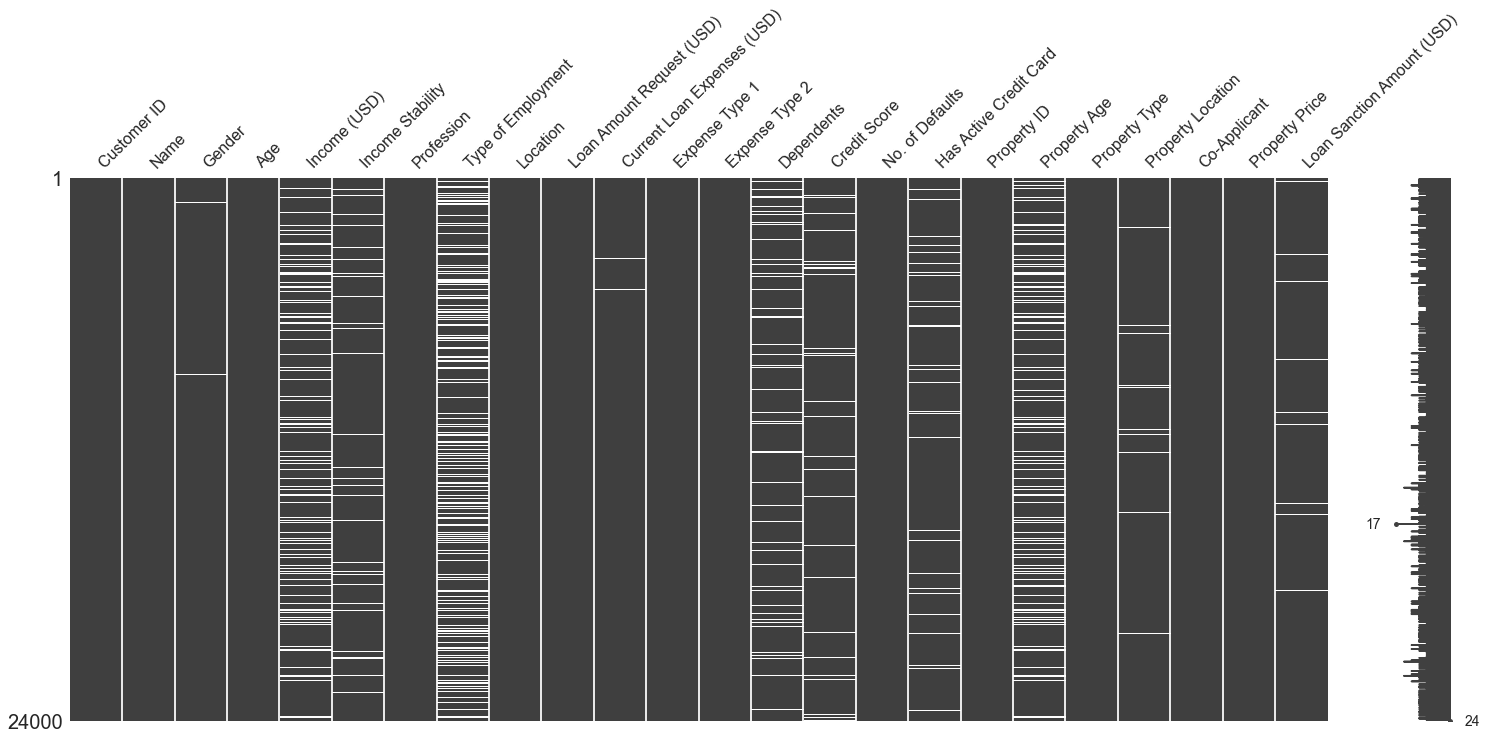

In [43]:
msno.matrix(loan_amt_train_copy)
plt.show()

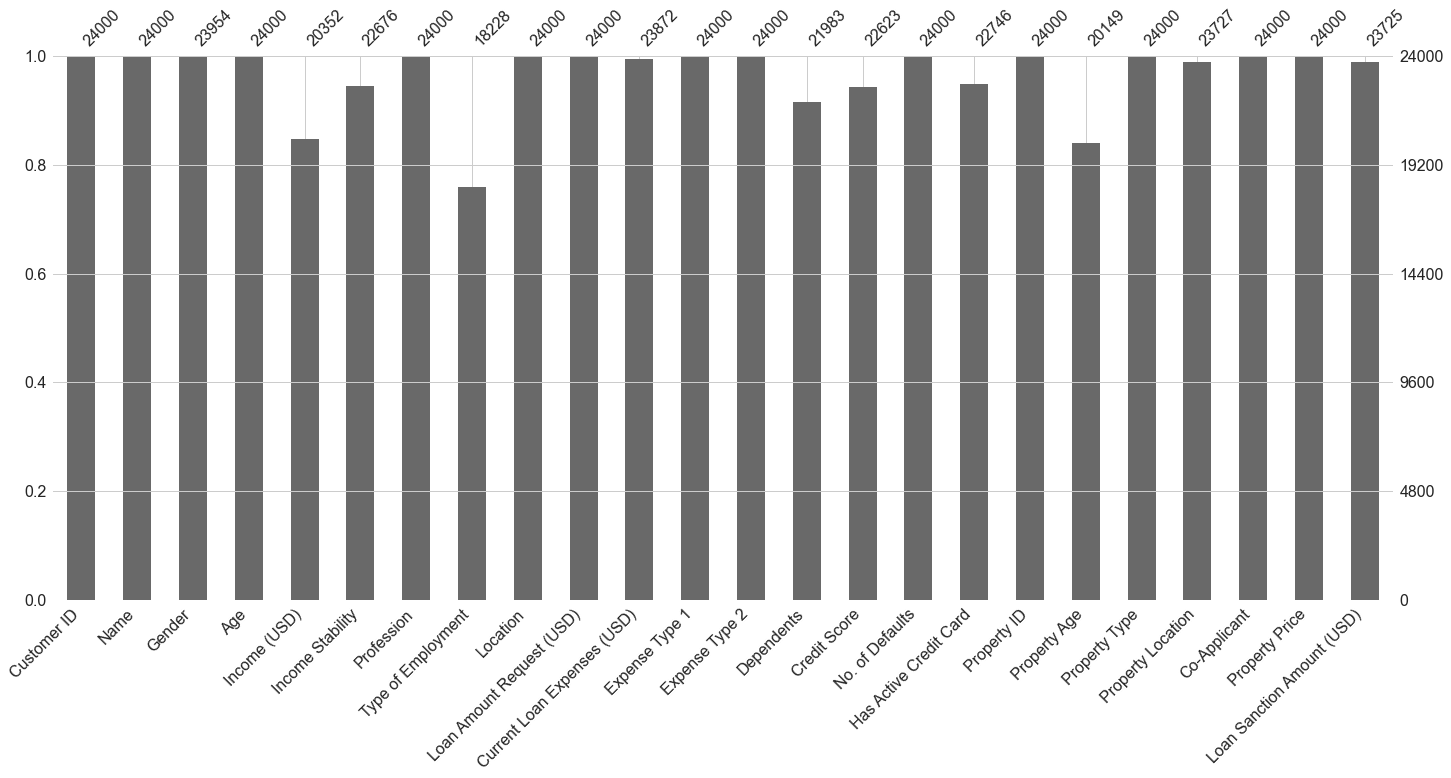

In [45]:
msno.bar(loan_amt_train_copy)
plt.show()

## 2.2 Functions used in the EDA of each feature

In [46]:
def value_cnt_norm_cal(df,feature):
    '''
    Function that will return the value count and frequency of each observation within a feature
    '''
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [94]:
def gen_info_feat(df,feature):
    '''
    function to create display general information about the feature
    '''
    match feature:
        case 'Age' | 'Income (USD)':
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(df,feature)
            print('Value count:\n{}'.format(value_cnt))

In [95]:
def create_bar_plot(df,feature):
    '''
    function to create a bar chart plot
    '''
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
    plt.xlabel('{}'.format(feature))
    plt.ylabel('Count')
    plt.title('{} count'.format(feature))
    return plt.show()

In [96]:
def create_donnut_pie_chart(df,feature):
    '''
    function to create a donnut pie chart
    '''
    ratio_size = value_cnt_norm_cal(df, feature)
    ratio_size_len = len(ratio_size.index)
    ratio_list = []
    for i in range(ratio_size_len):
        ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
    fig, ax = plt.subplots(figsize=(8,8))
    # %1.2f%% display decimals in the pie chart with 2 decimal places
    plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
    plt.title('Pie chart of {}'.format(feature))
    plt.legend(loc='best')
    plt.axis('equal')
    # add a circle at the center to transform it in a donut chart
    circle=plt.Circle( (0,0), 0.8, color='white')
    p=plt.gcf()
    p.gca().add_artist(circle)
    return plt.show()

In [97]:
def create_box_plot(df,feature):
    '''
    function to create a box plot
    '''
    fig, ax = plt.subplots(figsize=(2,8))
    sns.boxplot(y=df[feature])
    plt.title('{} distribution(Boxplot)'.format(feature))
    return plt.show()

In [98]:
def create_hist_plot(df,feature, the_bins=50):
    '''
    function to create a histogram plot
    '''
    fig, ax = plt.subplots(figsize=(18,10))
    sns.histplot(df[feature],bins=the_bins,kde=True)
    plt.title('{} distribution'.format(feature))
    return plt.show()

In [111]:
def missing_val_norm(df,feature):
    feat_nan_count = df[feature].isnull().sum()
    rows_count = df.shape[0]
    return 'The percentage of missing rows is {:.2f} %'.format(feat_nan_count * 100 / rows_count)

## 2.3. Univariate analysis

### 2.3.1 Gender

In [99]:
gen_info_feat(loan_amt_train_copy,'Gender')

Description:
count     23954
unique        2
top           M
freq      12087
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
M  12087      50.459213
F  11867      49.540787


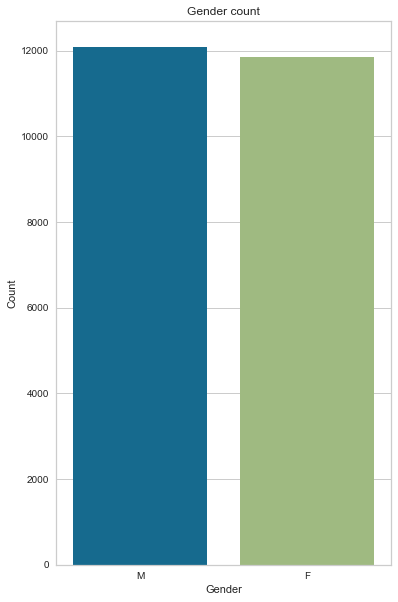

In [100]:
create_bar_plot(loan_amt_train_copy,'Gender')

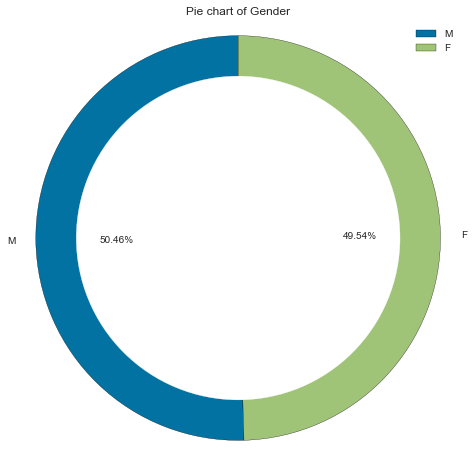

In [101]:
create_donnut_pie_chart(loan_amt_train_copy,'Gender')

Interpretation:
- We have almost the same number of Male vs Female (50.46% vs 49.54%)

### 2.3.2 Age

In [102]:
gen_info_feat(loan_amt_train_copy, 'Age')

Description:
count    24000.000000
mean        40.058417
std         16.029209
min         18.000000
25%         25.000000
50%         40.000000
75%         55.000000
max         65.000000
Name: Age, dtype: float64
**************************************************
Object type:
int64


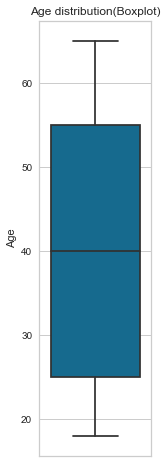

In [103]:
create_box_plot(loan_amt_train_copy, 'Age')

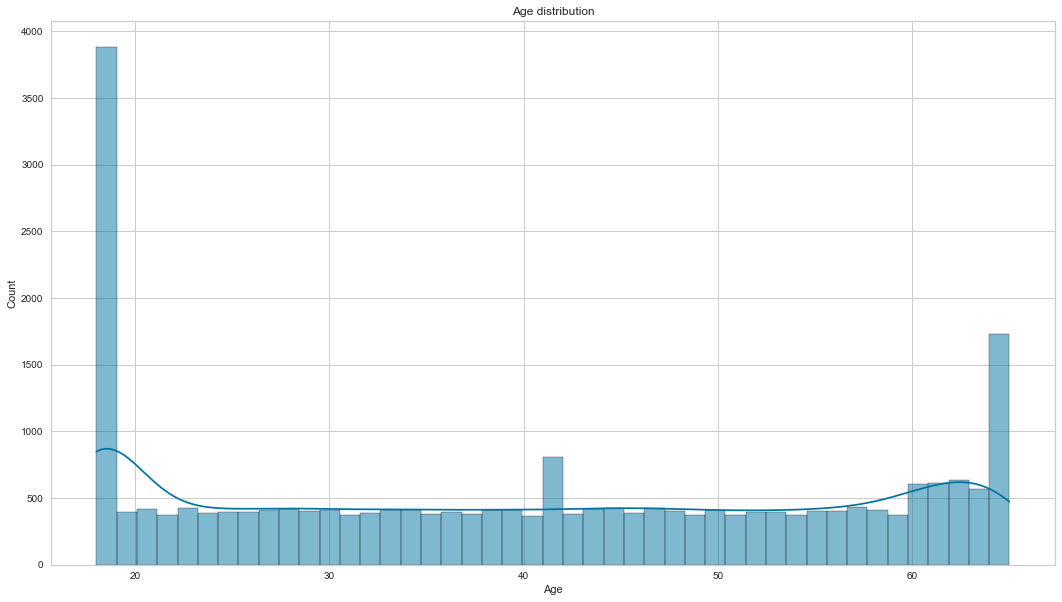

In [104]:
create_hist_plot(loan_amt_train_copy, 'Age', the_bins=45)

Interpretation:
- Age is not normally distributed
- We have a large number of applicants who are 18 and 65 years old
- Mean and median of age is 40 years old

# 2.3.3 Income

In [105]:
gen_info_feat(loan_amt_train_copy, 'Income (USD)')

Description:
count     20352.000000
mean       2567.533530
std        1775.075442
min         378.760000
25%        1652.707500
50%        2229.965000
75%        3092.775000
max      122966.280000
Name: Income (USD), dtype: float64
**************************************************
Object type:
float64


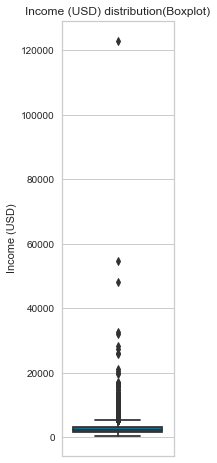

In [106]:
create_box_plot(loan_amt_train_copy, 'Income (USD)')

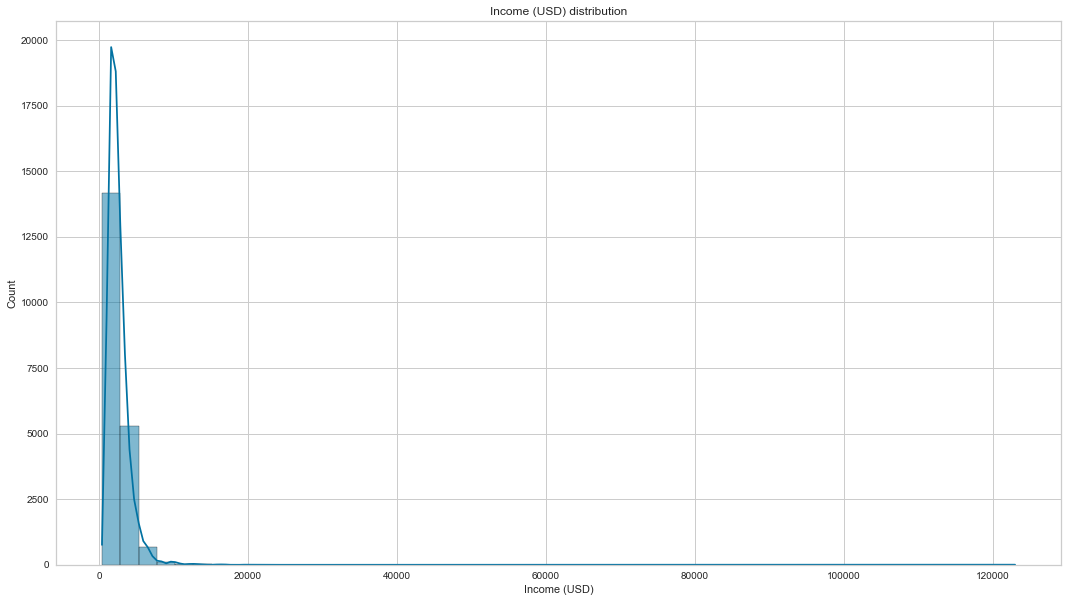

In [108]:
create_hist_plot(loan_amt_train_copy, 'Income (USD)', the_bins=50)

In [112]:
missing_val_norm(loan_amt_train_copy, 'Income (USD)')

'The percentage of missing rows is 15.20 %'

Interpretation:
- The Income feature has 15% of its data missing.
- The Income is positively skewed.
- The Income has a lot of outliers.
- The median income is $2229.

### 2.3.4 Income stability

In [113]:
gen_info_feat(loan_amt_train_copy,'Income Stability')

Description:
count     22676
unique        2
top         Low
freq      20617
Name: Income Stability, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
      Count  Frequency (%)
Low   20617      90.919915
High   2059       9.080085


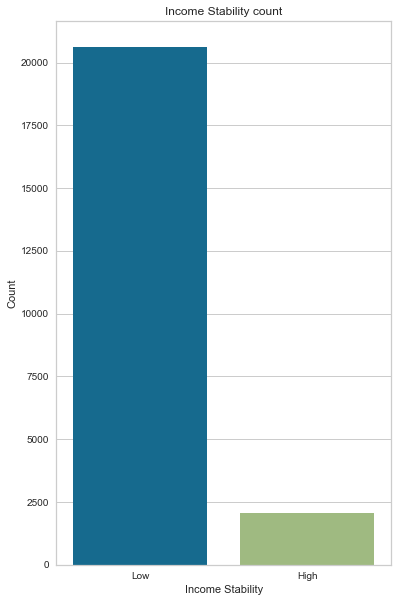

In [114]:
create_bar_plot(loan_amt_train_copy,'Income Stability')

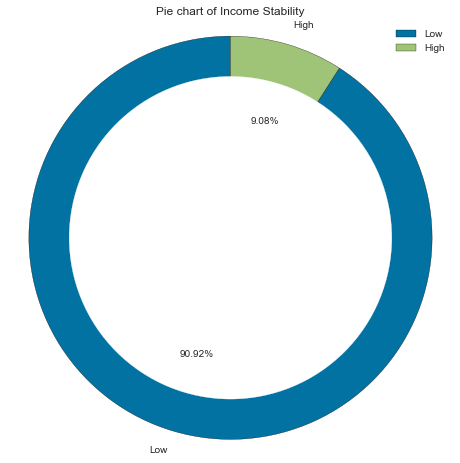

In [116]:
create_donnut_pie_chart(loan_amt_train_copy,'Income Stability')